In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/sample.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv


# **Importing Necessary Libraries**

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error,f1_score,accuracy_score,confusion_matrix,recall_score

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  StandardScaler, OneHotEncoder,MinMaxScaler,RobustScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import BaggingClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier
from sklearn.feature_selection import SelectKBest,chi2,mutual_info_classif
from sklearn.feature_selection import f_classif
import xgboost as xgb
import lightgbm as lgb



# **Importing the files**

In [3]:
train = pd.read_csv("/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv")
test = pd.read_csv("/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv")

# **EDA**

In [4]:
train.columns

Index(['ID', 'RecipeNumber', 'RecipeCode', 'RecipeName', 'CommentID', 'UserID',
       'UserName', 'UserReputation', 'CreationTimestamp', 'ReplyCount',
       'ThumbsUpCount', 'ThumbsDownCount', 'Rating', 'BestScore',
       'Recipe_Review'],
      dtype='object')

In [5]:
train.head(5)

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Recipe_Review
0,70,71,12259,Banana Bars with Cream Cheese Frosting,sp_aUSaElGf_12259_c_149978,u_1oKVaBmiEKwAFyiHrDLoWpbel0J,misscoffeepot,20,1622717078,0,0,0,5,100,great recipe! I have made them just as written...
1,72,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_310332,u_1oKZeRIXYzGNhGW8OMR3O4lX1ih,MichelleMalone,1,1622717852,0,0,1,5,100,This is an easy and quick recipe that is great...
2,458,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_206522,u_1oKYHUtdaD48KJCDYq5wfpAUxWz,jeannem32,1,1622717357,0,0,0,3,100,I think I was looking for something extra spec...
3,7,50,100276,Grilled Huli Huli Chicken,sp_aUSaElGf_100276_c_434088,u_1oKZCQcKQZdQhDVBS7oISc216VA,ds422,1,1622648899,0,0,0,5,100,This is our favorite grilled chicken recipe. ...
4,60,12,19731,Cauliflower Soup,sp_aUSaElGf_19731_c_387011,u_1oKd4sudZQPgu6YALiC7bW7mKMs,SusanHoward,1,1622718260,0,0,0,4,100,Great basic recipe. I added 2 teaspoons Tuscan...


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13636 entries, 0 to 13635
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 13636 non-null  int64 
 1   RecipeNumber       13636 non-null  int64 
 2   RecipeCode         13636 non-null  int64 
 3   RecipeName         13636 non-null  object
 4   CommentID          13636 non-null  object
 5   UserID             13636 non-null  object
 6   UserName           13636 non-null  object
 7   UserReputation     13636 non-null  int64 
 8   CreationTimestamp  13636 non-null  int64 
 9   ReplyCount         13636 non-null  int64 
 10  ThumbsUpCount      13636 non-null  int64 
 11  ThumbsDownCount    13636 non-null  int64 
 12  Rating             13636 non-null  int64 
 13  BestScore          13636 non-null  int64 
 14  Recipe_Review      13634 non-null  object
dtypes: int64(10), object(5)
memory usage: 1.6+ MB


In [7]:
print(train['ID'].nunique())#not required
print(train['RecipeName'].nunique())#categorical
print(train['RecipeCode'].nunique())#categorical
print(train['RecipeNumber'].nunique())#categorical
print(train['CommentID'].nunique())#dropping- has no affect on the data set as the number of values is 13636
print(train['UserID'].nunique())#Dropping
print(train['UserName'].nunique())#Dropping
print(train['UserReputation'].nunique())#Categorical
print(train['CreationTimestamp'].nunique())#dropping
print(train['ReplyCount'].nunique())#Numerical
print(train['ThumbsUpCount'].nunique())#Numerical
print(train['ThumbsDownCount'].nunique())#Numerical
     

701
100
100
100
13636
10783
10620
20
2422
4
57
51


In [8]:
for i in train.columns:
    print(str(train[i].value_counts()))
#thumbs up count for test and train,thumbs down count for test and train, best score for train and test    
    

ID
19     85
25     83
90     82
69     82
71     81
       ..
552     1
706     1
572     1
608     1
675     1
Name: count, Length: 701, dtype: int64
RecipeNumber
3     553
1     483
2     372
9     313
13    307
     ... 
54     68
97     65
91     64
72     64
61     19
Name: count, Length: 100, dtype: int64
RecipeCode
2832     553
14299    483
3309     372
42083    313
32480    307
        ... 
35766     68
34347     65
3683      64
1821      64
17022     19
Name: count, Length: 100, dtype: int64
RecipeName
Cheeseburger Soup             553
Creamy White Chili            483
Best Ever Banana Bread        372
Enchilada Casser-Ole!         313
Basic Homemade Bread          307
                             ... 
Cheeseburger Paradise Soup     68
Lime Chicken Tacos             65
Caramel Heavenlies             64
Blueberry French Toast         64
Vegetarian Linguine            19
Name: count, Length: 100, dtype: int64
CommentID
sp_aUSaElGf_12259_c_149978    1
sp_aUSaElGf_9735_c_404065  

***Converting CreationTimestamp to Hour,Day,Day of the week, Month, Year***

In [9]:
import datetime

def unix_timestamp(timestamp):

    formatted_date = datetime.datetime.utcfromtimestamp(timestamp)
    day = formatted_date.day
    month = formatted_date.month
    year = formatted_date.year
    hour = formatted_date.hour
    weekday = formatted_date.weekday()
    minute=formatted_date.minute
    return day, month, year, hour,weekday,minute

In [10]:
day_list = []
month_list = []
year_list = []
hour_list=[]
weekday_list=[]
minute_list=[]
testday_list = []
testmonth_list = []
testyear_list = []
testhour_list=[]
testweekday_list=[]
testminute_list=[]

for index, row in train.iterrows():
    day, month, year,hour,weekday,minute = unix_timestamp(row['CreationTimestamp'])
    day_list.append(day)
    month_list.append(month)
    year_list.append(year)
    hour_list.append(hour)
    weekday_list.append(weekday)
    minute_list.append(minute)
for index, row in test.iterrows():
    tday, tmonth, tyear,thour,tweekday,tminute = unix_timestamp(row['CreationTimestamp'])
    testday_list.append(tday)
    testmonth_list.append(tmonth)
    testyear_list.append(tyear)
    testhour_list.append(thour)
    testweekday_list.append(tweekday)  
    testminute_list.append(tminute)

train['Day'] = day_list
train['Month'] = month_list
train['Year'] = year_list
train['Hour']=hour_list
train['Weekday']=weekday_list
train['Minute']=minute_list
test['Day'] = testday_list
test['Month'] = testmonth_list
test['Year'] = testyear_list
test['Hour']=testhour_list
test['Weekday']=testweekday_list
test['Minute']=testminute_list

#print(train)'''

# ***Imputation of Missing Data***

In [11]:
train.isna().sum()

ID                   0
RecipeNumber         0
RecipeCode           0
RecipeName           0
CommentID            0
UserID               0
UserName             0
UserReputation       0
CreationTimestamp    0
ReplyCount           0
ThumbsUpCount        0
ThumbsDownCount      0
Rating               0
BestScore            0
Recipe_Review        2
Day                  0
Month                0
Year                 0
Hour                 0
Weekday              0
Minute               0
dtype: int64

In [12]:
test.isna().sum()

ID                   0
RecipeNumber         0
RecipeCode           0
RecipeName           0
CommentID            0
UserID               0
UserName             0
UserReputation       0
CreationTimestamp    0
ReplyCount           0
ThumbsUpCount        0
ThumbsDownCount      0
BestScore            0
Recipe_Review        0
Day                  0
Month                0
Year                 0
Hour                 0
Weekday              0
Minute               0
dtype: int64

***Filling the unknown values in Recipe Review***

In [13]:
train['Recipe_Review'].fillna("Unknown", inplace=True)


/tmp/ipykernel_19/2026751883.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Recipe_Review'].fillna("Unknown", inplace=True)


# ***Data Visualization***

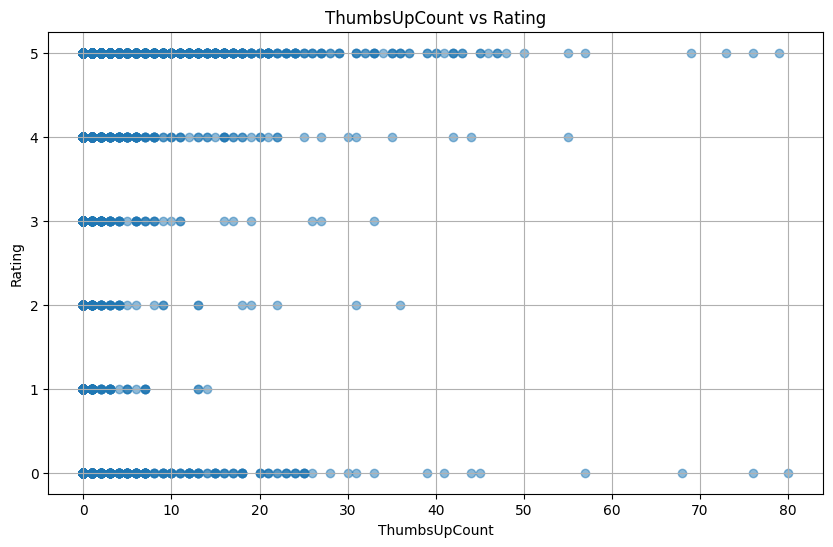

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(train['ThumbsUpCount'], train['Rating'], alpha=0.5)
plt.title('ThumbsUpCount vs Rating')
plt.xlabel('ThumbsUpCount')
plt.ylabel('Rating')
plt.grid(True)
plt.show()

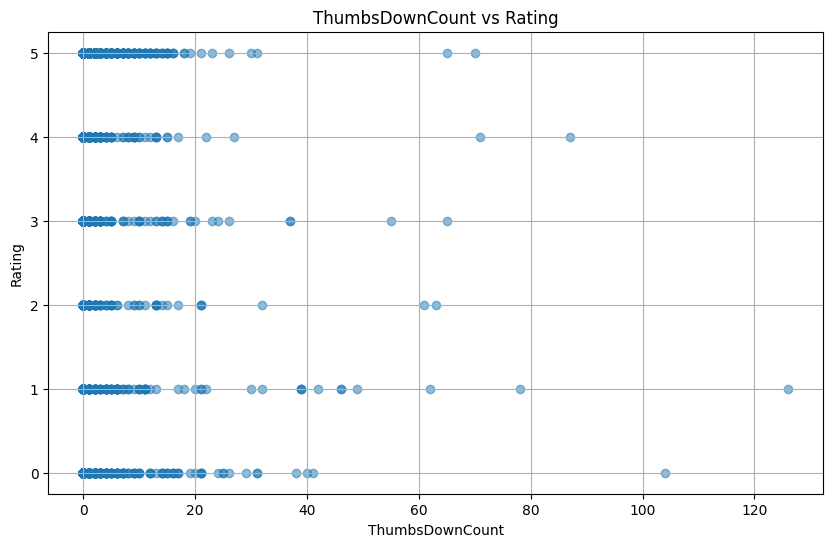

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(train['ThumbsDownCount'], train['Rating'], alpha=0.5)
plt.title('ThumbsDownCount vs Rating')
plt.xlabel('ThumbsDownCount')
plt.ylabel('Rating')
plt.grid(True)
plt.show()

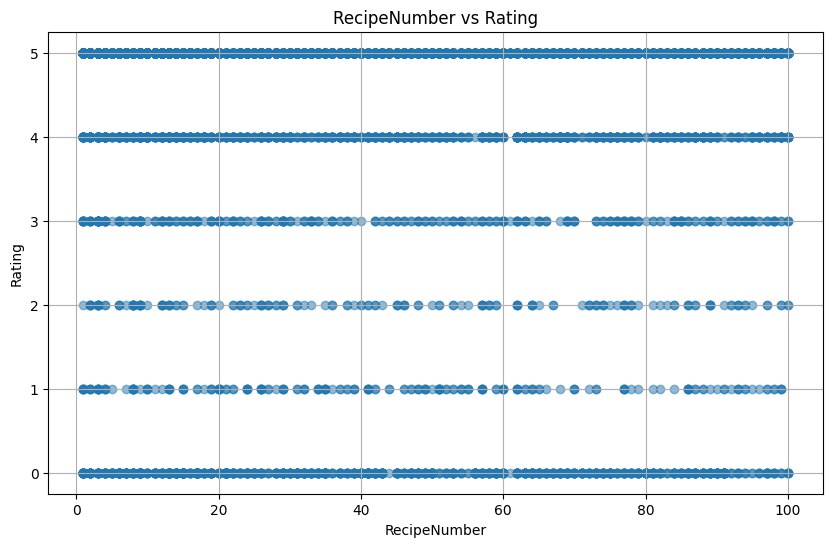

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(train['RecipeNumber'], train['Rating'], alpha=0.5)
plt.title('RecipeNumber vs Rating')
plt.xlabel('RecipeNumber')
plt.ylabel('Rating')
plt.grid(True)
plt.show()

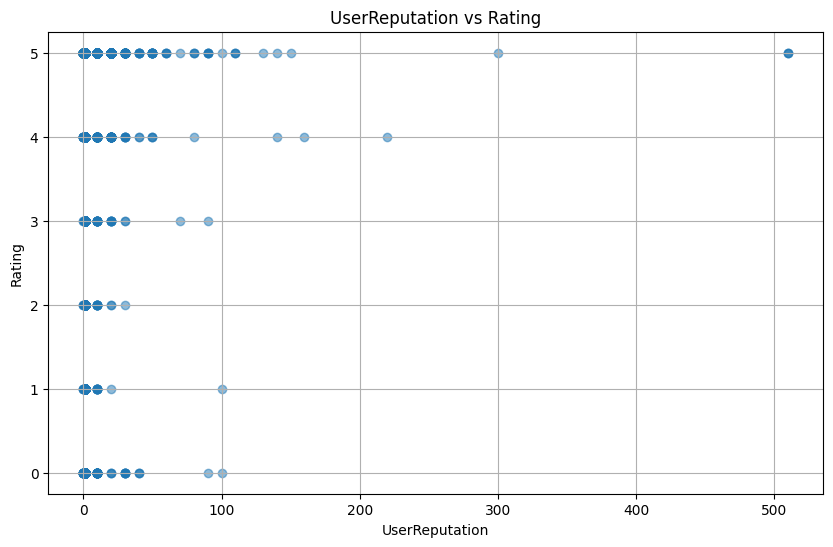

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(train['UserReputation'], train['Rating'], alpha=0.5)
plt.title('UserReputation vs Rating')
plt.xlabel('UserReputation')
plt.ylabel('Rating')
plt.grid(True)
plt.show()

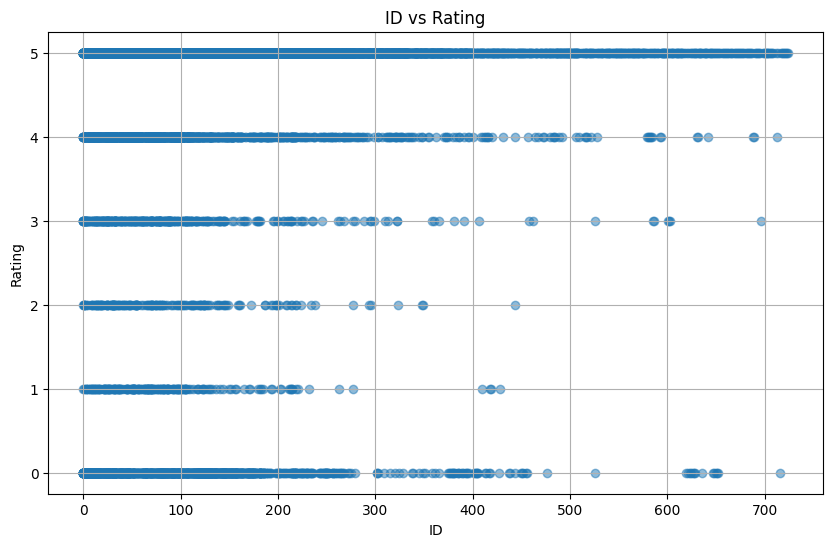

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(train['ID'], train['Rating'], alpha=0.5)
plt.title('ID vs Rating')
plt.xlabel('ID')
plt.ylabel('Rating')
plt.grid(True)
plt.show()

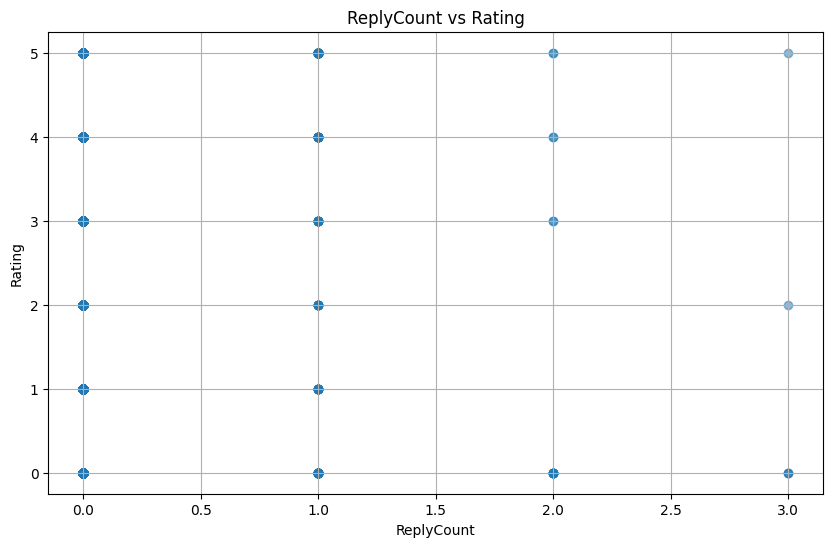

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(train['ReplyCount'], train['Rating'], alpha=0.5)
plt.title('ReplyCount vs Rating')
plt.xlabel('ReplyCount')
plt.ylabel('Rating')
plt.grid(True)
plt.show()

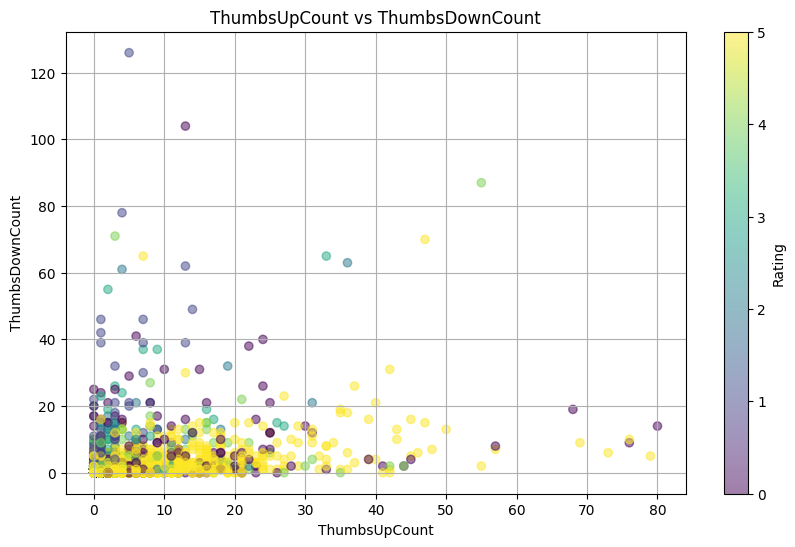

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(train['ThumbsUpCount'], train['ThumbsDownCount'], c=train['Rating'], cmap='viridis', alpha=0.5)
plt.title('ThumbsUpCount vs ThumbsDownCount')
plt.xlabel('ThumbsUpCount')
plt.ylabel('ThumbsDownCount')
plt.colorbar(label='Rating')
plt.grid(True)
plt.show()

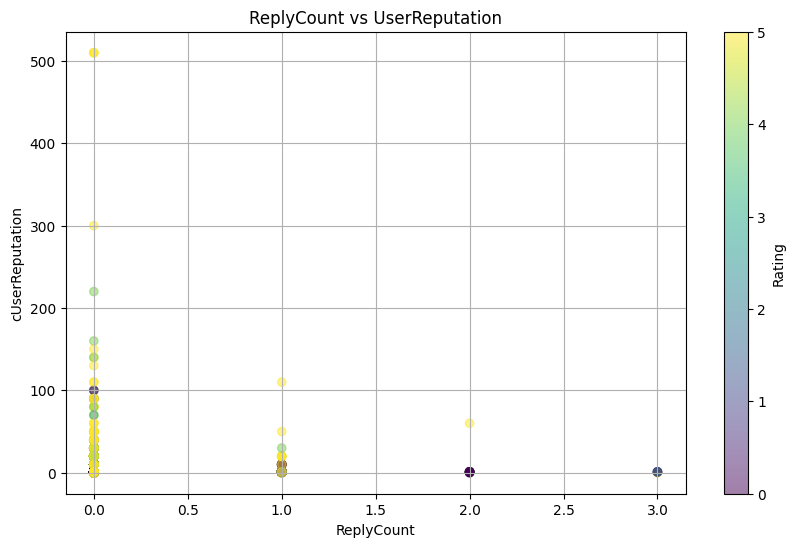

In [21]:
plt.figure(figsize=(10, 6))
plt.scatter(train['ReplyCount'], train['UserReputation'], c=train['Rating'], cmap='viridis', alpha=0.5)
plt.title('ReplyCount vs UserReputation')
plt.xlabel('ReplyCount')
plt.ylabel('cUserReputation')
plt.colorbar(label='Rating')
plt.grid(True)
plt.show()

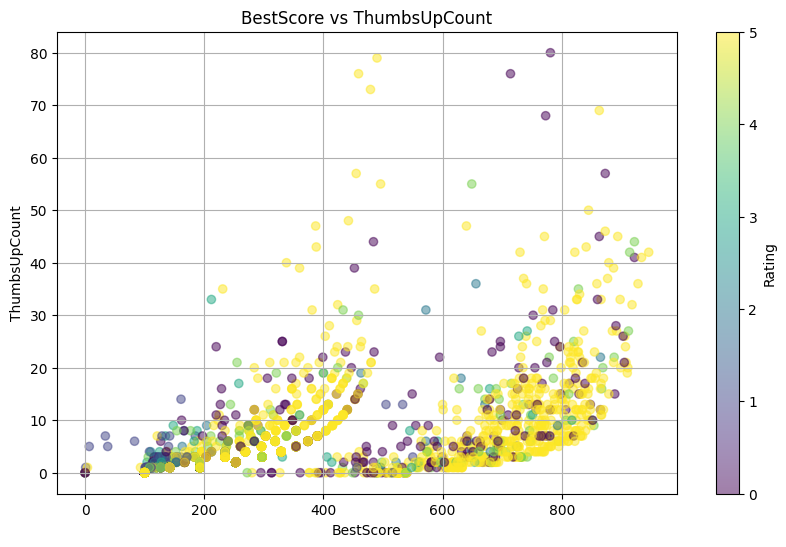

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(train['BestScore'], train['ThumbsUpCount'], c=train['Rating'], cmap='viridis', alpha=0.5)
plt.title('BestScore vs ThumbsUpCount')
plt.xlabel('BestScore')
plt.ylabel('ThumbsUpCount')
plt.colorbar(label='Rating')
plt.grid(True)
plt.show()

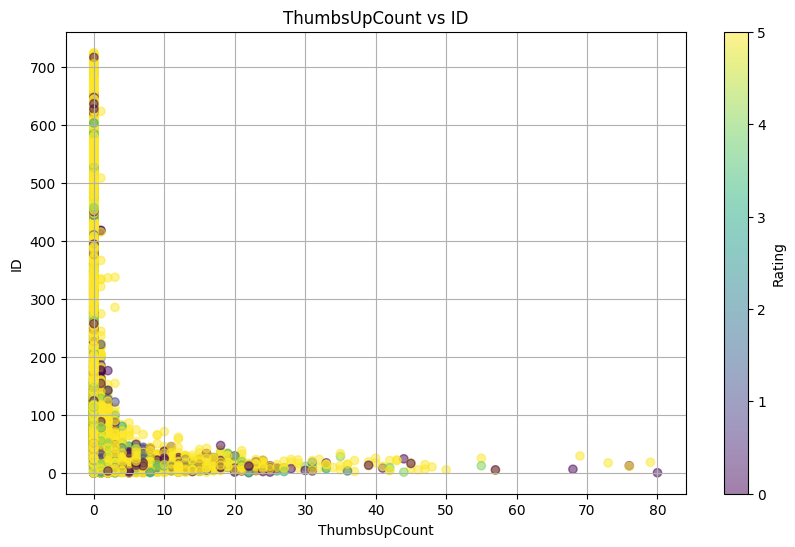

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(train['ThumbsUpCount'], train['ID'], c=train['Rating'], cmap='viridis', alpha=0.5)
plt.title('ThumbsUpCount vs ID')
plt.xlabel('ThumbsUpCount')
plt.ylabel('ID')
plt.colorbar(label='Rating')
plt.grid(True)
plt.show()

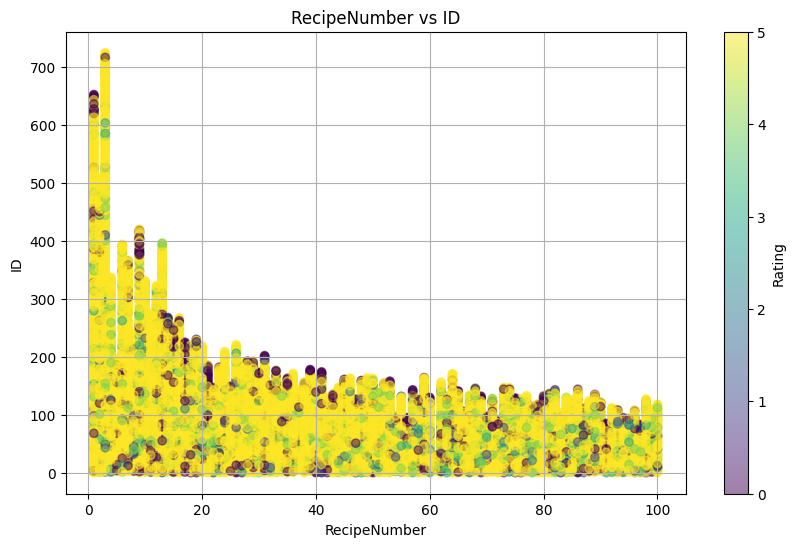

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(train['RecipeNumber'], train['ID'], c=train['Rating'], cmap='viridis', alpha=0.5)
plt.title('RecipeNumber vs ID')
plt.xlabel('RecipeNumber')
plt.ylabel('ID')
plt.colorbar(label='Rating')
plt.grid(True)
plt.show()

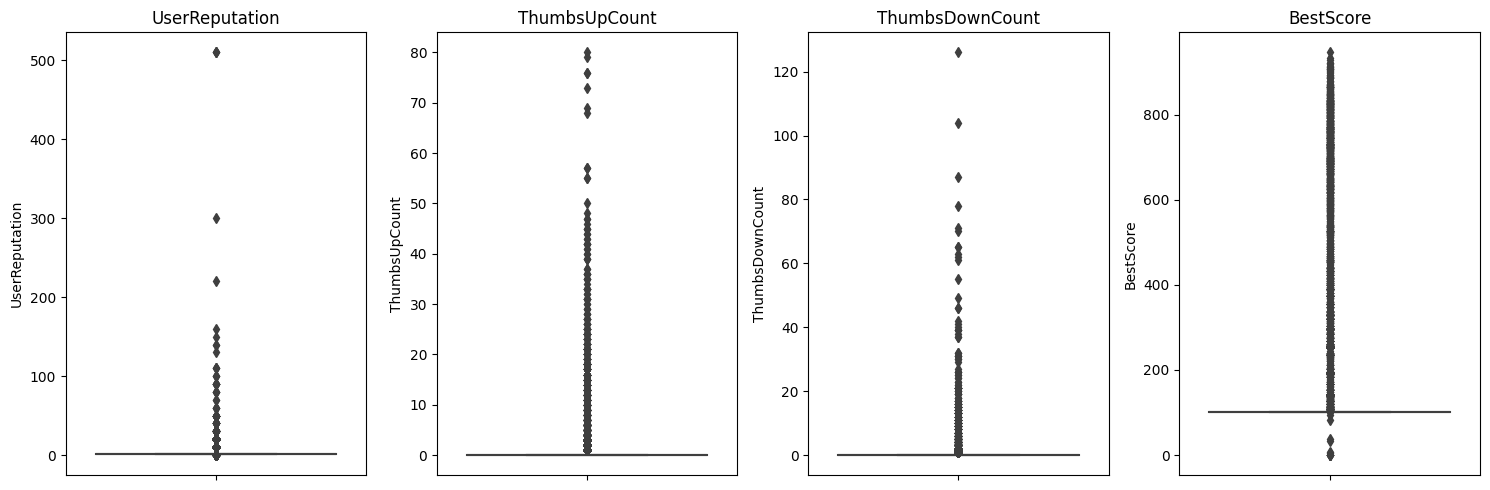

In [25]:
col = ['UserReputation', 'ThumbsUpCount', 'ThumbsDownCount', 'BestScore']


fig, axes = plt.subplots(nrows=1, ncols=len(col), figsize=(15, 5))


for idx, column in enumerate(col):
    sns.boxplot(y=train[column], ax=axes[idx])
    axes[idx].set_title(column)

plt.tight_layout()
plt.show()

In [26]:
xytrain=train.drop(['RecipeName','Recipe_Review','UserName','UserID','CreationTimestamp','CommentID'],axis=1)
xytrain.corr()['Rating']

ID                 0.049673
RecipeNumber      -0.043127
RecipeCode        -0.020714
UserReputation     0.015038
ReplyCount        -0.124860
ThumbsUpCount     -0.051752
ThumbsDownCount   -0.142273
Rating             1.000000
BestScore         -0.036719
Day               -0.050167
Month             -0.025126
Year              -0.050220
Hour              -0.036977
Weekday            0.030811
Minute             0.052417
Name: Rating, dtype: float64

***ID tends to show the most positive correlation with Rating.***
***Positive correlation:ID,UserReputation,Weekday***
***Negative Correlation: RecipeNumber,RecipeCode,ReplyCount,ThumbsUpCount,ThumbsDownCount,Hour,Day,Month,Weekday,Year,BestScore***

In [27]:
xytrain.corr().style.background_gradient(cmap='viridis')


,ID,RecipeNumber,RecipeCode,UserReputation,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Day,Month,Year,Hour,Weekday,Minute
ID,1.000000,-0.494620,-0.157264,-0.063538,-0.093525,-0.226282,-0.136876,0.049673,-0.318778,-0.169981,-0.061386,-0.169027,-0.172203,0.082253,0.123231
RecipeNumber,-0.494620,1.000000,0.299735,0.022084,0.026537,0.064797,0.053027,-0.043127,0.086233,0.035738,0.007061,0.030267,0.022926,-0.021711,0.013251
RecipeCode,-0.157264,0.299735,1.000000,0.015980,-0.019270,0.014405,0.003341,-0.020714,0.025928,0.010261,-0.012907,0.006995,0.004630,-0.020610,0.010374
UserReputation,-0.063538,0.022084,0.015980,1.000000,0.014045,0.053825,0.023986,0.015038,0.126701,0.094721,0.030281,0.162917,0.058706,0.008120,-0.029430
ReplyCount,-0.093525,0.026537,-0.019270,0.014045,1.000000,0.220929,0.293614,-0.124860,0.210352,0.167452,0.045198,0.149397,0.111571,-0.089570,-0.045872
ThumbsUpCount,-0.226282,0.064797,0.014405,0.053825,0.220929,1.000000,0.392564,-0.051752,0.693532,0.379472,0.145364,0.248249,0.324584,-0.184889,-0.099446
ThumbsDownCount,-0.136876,0.053027,0.003341,0.023986,0.293614,0.392564,1.000000,-0.142273,0.227341,0.197873,0.098779,0.161694,0.173244,-0.101516,-0.067328
Rating,0.049673,-0.043127,-0.020714,0.015038,-0.124860,-0.051752,-0.142273,1.000000,-0.036719,-0.050167,-0.025126,-0.050220,-0.036977,0.030811,0.052417
BestScore,-0.318778,0.086233,0.025928,0.126701,0.210352,0.693532,0.227341,-0.036719,1.000000,0.696636,0.170093,0.595654,0.444651,-0.182046,-0.138915
Day,-0.169981,0.035738,0.010261,0.094721,0.167452,0.379472,0.197873,-0.050167,0.696636,1.000000,0.063519,0.579765,0.329964,-0.097252,-0.065420


* ***Best score and ThumbsUpCount have a positive correlation***
* ***Best score and Day have a positive correlation***
* ***RecipeNumber and ID have a negative correlation***
* ***ThumbsUpCount and ID have a negative correlation***

******

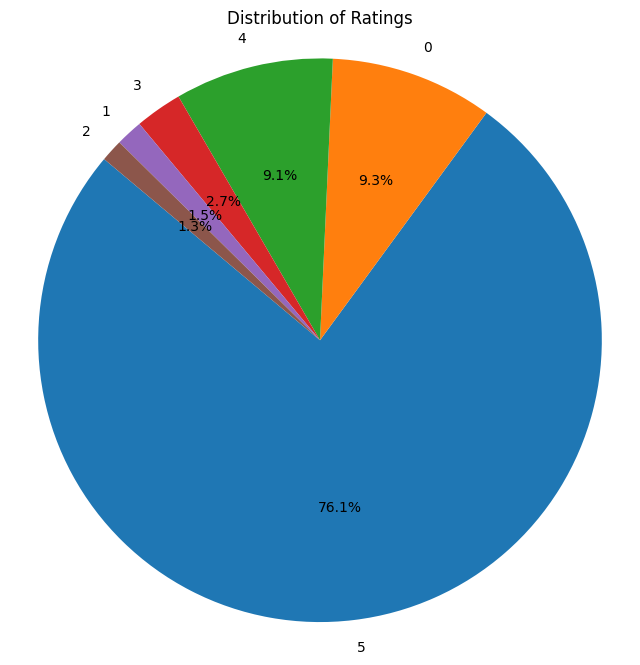

In [28]:
rating_counts = train['Rating'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Ratings')
plt.axis('equal')  
plt.show()

***We can see that Rating '5' has the most values, followed by 0 and then 4***

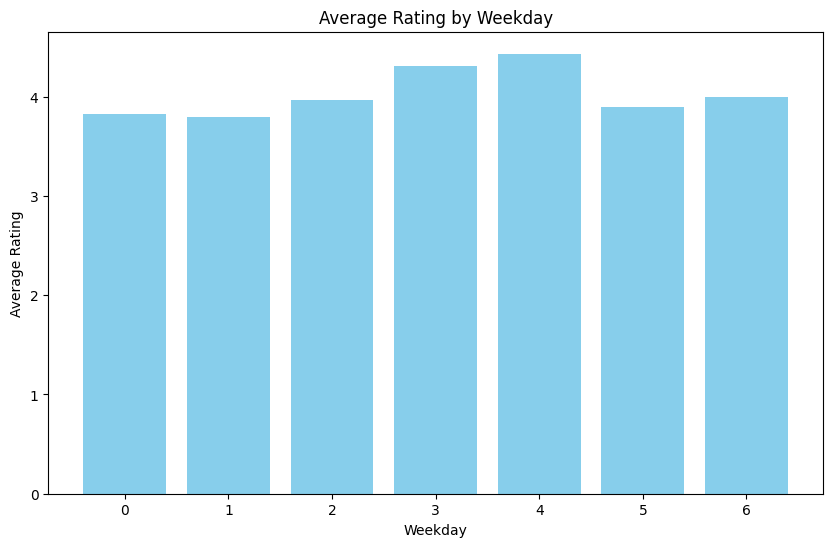

In [29]:
ratingbyweekday = train.groupby('Weekday')['Rating'].mean()


plt.figure(figsize=(10, 6))
plt.bar(ratingbyweekday.index, ratingbyweekday.values, color='skyblue')
plt.xlabel('Weekday')
plt.ylabel('Average Rating')
plt.title('Average Rating by Weekday')
 
plt.show()

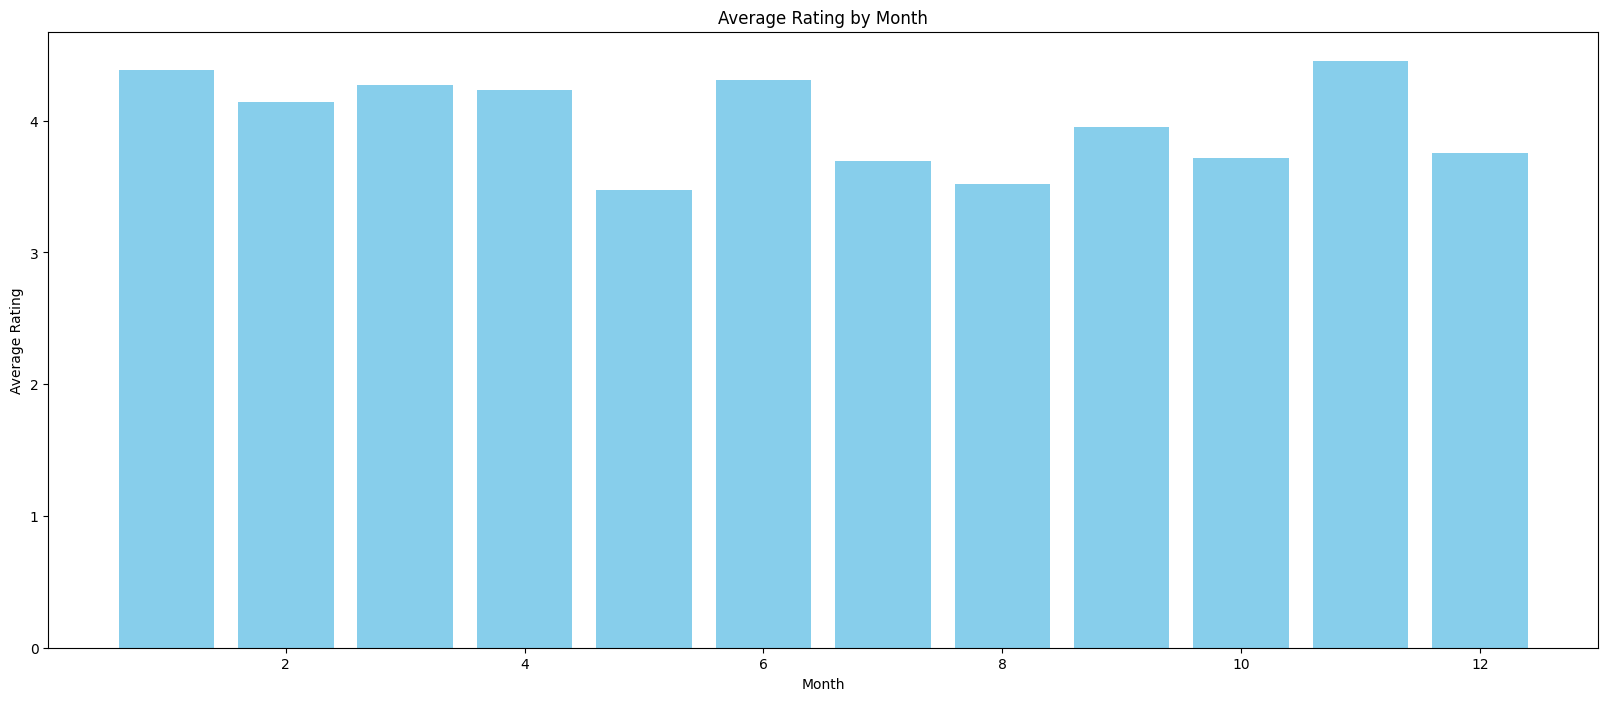

In [30]:
ratingbymonth = train.groupby('Month')['Rating'].mean()


plt.figure(figsize=(20, 8))
plt.bar(ratingbymonth.index, ratingbymonth.values, color='skyblue')
plt.xlabel('Month')
plt.ylabel('Average Rating')
plt.title('Average Rating by Month')

plt.show()

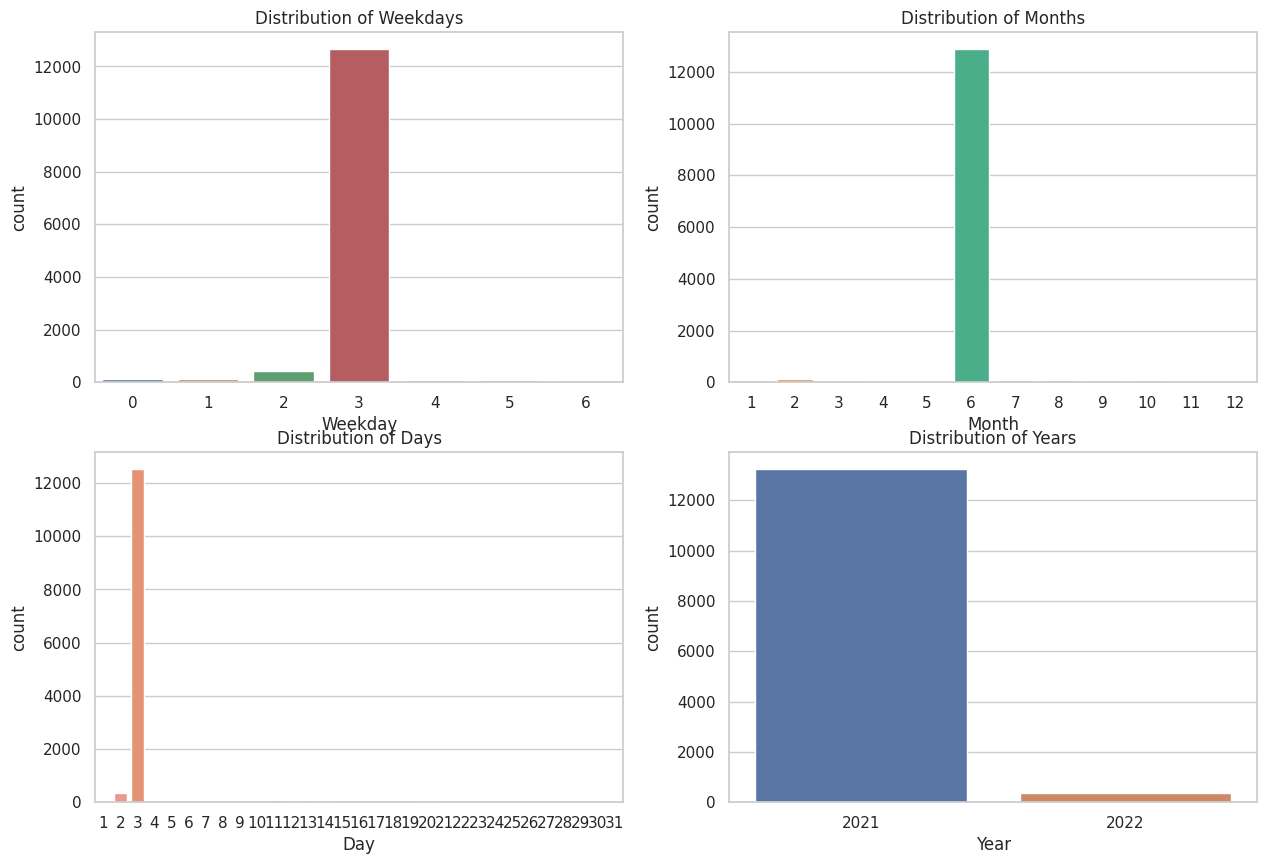

In [31]:
sns.set(style="whitegrid")


fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.countplot(x='Weekday', data=train, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Weekdays')


sns.countplot(x='Month', data=train, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Months')

sns.countplot(x='Day', data=train, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Days')


sns.countplot(x='Year', data=train, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Years')



plt.show()



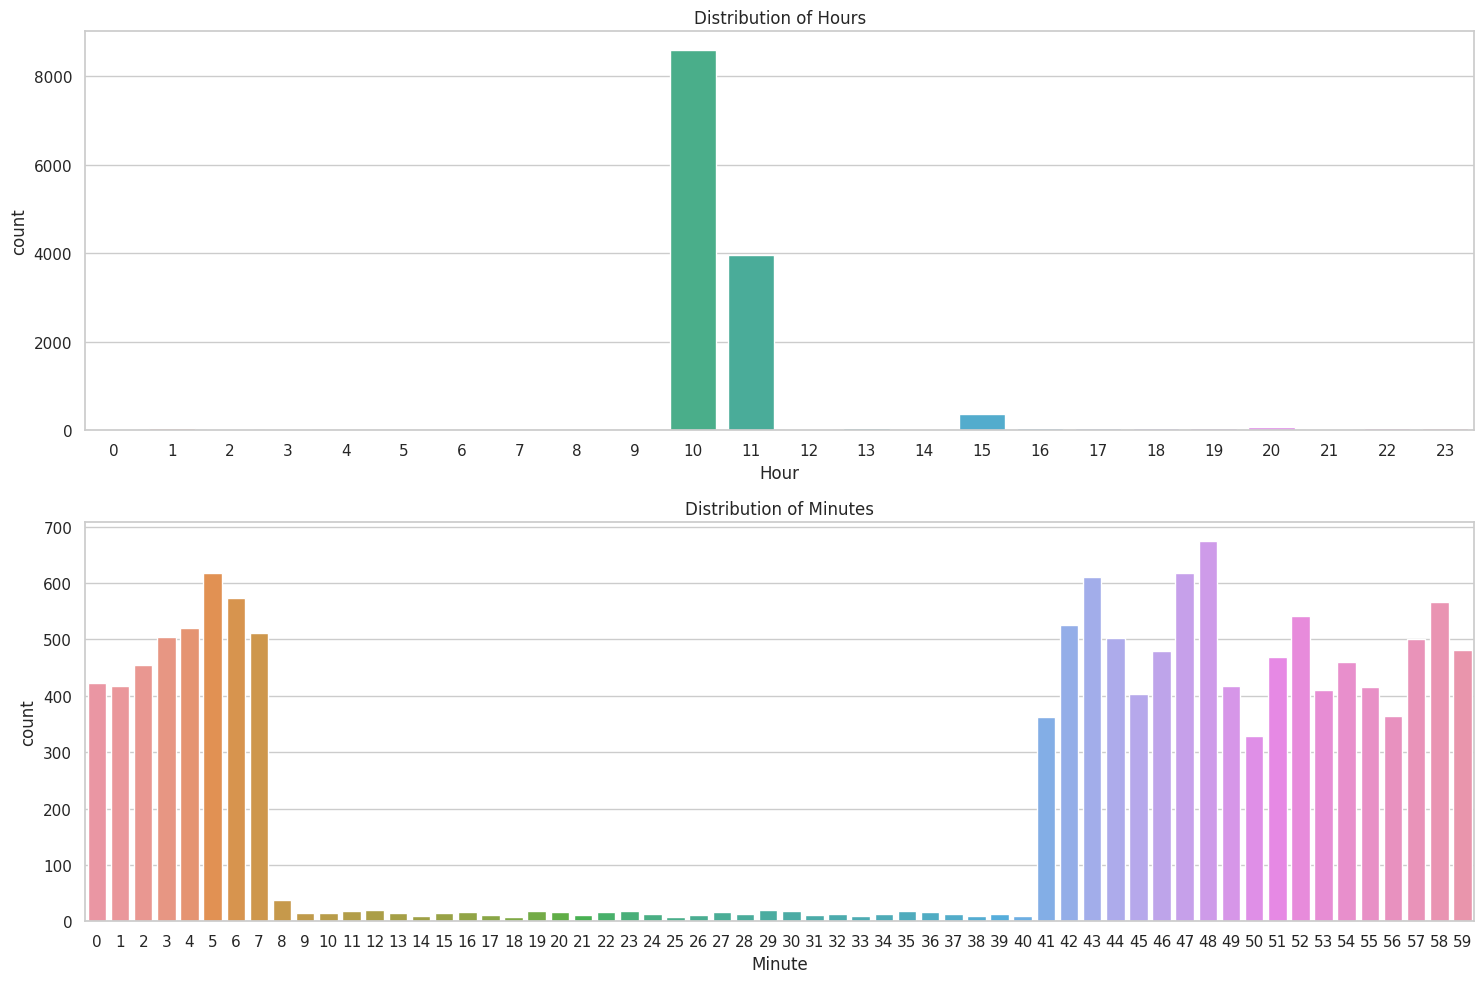

In [32]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

sns.countplot(x='Hour', data=train, ax=axes[0])
axes[0].set_title('Distribution of Hours')

sns.countplot(x='Minute', data=train, ax=axes[1])
axes[1].set_title('Distribution of Minutes')

plt.tight_layout()
plt.show()


***1. We can see that the data is unbalanced- Wednesday,June,3rd of every month and 2021 has the most number. Since the dataset overwhelmingly has these values- these 4 columns will not be required to determine***

***To check the relationship between Recipe Number, Recipe Code and Recipe Name***

In [33]:
train[(train['RecipeNumber']==88) & (train['RecipeCode']==8202)]

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,...,ThumbsDownCount,Rating,BestScore,Recipe_Review,Day,Month,Year,Hour,Weekday,Minute
1,72,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_310332,u_1oKZeRIXYzGNhGW8OMR3O4lX1ih,MichelleMalone,1,1622717852,0,...,1,5,100,This is an easy and quick recipe that is great...,3,6,2021,10,3,57
293,57,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_420283,u_1oKdS6ds0p919qkWKLCj73DG1jo,Rita,1,1622718454,0,...,0,5,100,This soup is WONDERFUL. I don&#39;t like stew...,3,6,2021,11,3,7
311,38,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_396683,u_1oKVakhxVIBNUxgvWPjxZBGNwrV,grandmascooking22,10,1622718302,0,...,2,5,203,I made this recipe when we went to visit our k...,3,6,2021,11,3,5
380,10,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_223XA5OU5cGY1YEGRQWp8GDyyXN,u_aHRV9Y1HCmxC,SARA418,1,1639067175,1,...,9,4,779,This was really good! I tweaked it a little to...,9,12,2021,16,3,26
382,118,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_235126,u_1oKVkYND6nGiN8ZyAJzl9M0I1S5,daabbott,1,1622717505,0,...,0,5,100,LOVE this recipe! I make it at least once eve...,3,6,2021,10,3,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13081,83,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_287117,u_1oKZNo9a9WhGStAFM09xEDbLAC3,JamieCossey,1,1622717736,0,...,0,5,100,The taco seasoning &amp; ranch make this recip...,3,6,2021,10,3,55
13165,116,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_350468,u_1oKbZ7pNIpN6tKCSKrijQIeISar,Chels34,1,1622718105,0,...,0,5,100,"Very easy and tasty! Freezes well, too.",3,6,2021,11,3,1
13225,7,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_22b1YHK94hEKAFxzQ9ManoBPEQp,u_pAR5N9OZcVjF,Emarie,1,1640091518,0,...,5,5,828,So good! The only thing I added that was not o...,21,12,2021,12,1,58
13490,41,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_404067,u_1oKcBa7OxZoAKgEY3ncFqPAIe3U,JeanetteCornforth,1,1622718351,0,...,0,5,100,Love this recipe! Not a fan of pinto beans so ...,3,6,2021,11,3,5


***RecipeCode,RecipeName and RecipeNumber have the same data***

# **Feature Engineering**

***PCA***

In [34]:
'''traindense = X_train_transformed.toarray()
test_dense = X_test_transformed.toarray()


pca = PCA(n_components=100) 
trainpca = pca.fit_transform(train_dense)



testpca = pca.transform(testdense)'''

'traindense = X_train_transformed.toarray()\ntest_dense = X_test_transformed.toarray()\n\n\npca = PCA(n_components=100) \ntrainpca = pca.fit_transform(train_dense)\n\n\n\ntestpca = pca.transform(testdense)'

***Numerical feature selection***

In [35]:

kbestfeatures = SelectKBest(score_func=chi2, k=6)
numcol=train.drop(['RecipeName','UserReputation','Month','Day','Year','Recipe_Review','UserID','CommentID','CreationTimestamp','ID','UserName','Rating'],axis=1)
X1 = kbestfeatures.fit_transform(numcol, train['Rating'])
selectedfeatureindex = kbestfeatures.get_support(indices=True)
selectedfeaturenames = numcol.columns[selectedfeatureindex]
print("Selected features:", selectedfeaturenames)

Selected features: Index(['RecipeNumber', 'RecipeCode', 'ThumbsUpCount', 'ThumbsDownCount',
       'BestScore', 'Minute'],
      dtype='object')


***So, for numerical columns- I took ThumbsUpCount,ThumbsDownCount,BestScore and ReplyCount. I didn't take RecipeNumber and RecipeCode because they are practically the same as RecipeName.***

***Categorical feature selection***

In [36]:
catcol=train.drop(['ReplyCount','ThumbsUpCount','ThumbsDownCount','BestScore','Recipe_Review','RecipeName','CommentID','CreationTimestamp','UserID','UserName','Minute','Hour','Rating'],axis=1)

kbestfeatures = SelectKBest(score_func=mutual_info_classif, k=6)
X1 = kbestfeatures.fit_transform(catcol,train['Rating'])
selectedfeatureindex = kbestfeatures.get_support(indices=True)
selectedfeaturenames = catcol.columns[selectedfeatureindex]
print("Selected features:", selectedfeaturenames)

Selected features: Index(['ID', 'RecipeCode', 'Day', 'Month', 'Year', 'Weekday'], dtype='object')


***For categorical data, I skipped ID because, as I inferred from the graph, no pattern was shown with the Rating. Instead of RecipeNumber and RecipeCode, my model actually worked with Recipe Name for categorical data better so I went ahead with that and User Reputation. I didn't choose Day and Month because they were concentrated only on a single value, which isn't of much use for prediction***

# ***Train Test Split***

In [37]:
ytrain=train['Rating']

In [38]:

train.drop('Rating',axis=1,inplace=True)
train.columns

Index(['ID', 'RecipeNumber', 'RecipeCode', 'RecipeName', 'CommentID', 'UserID',
       'UserName', 'UserReputation', 'CreationTimestamp', 'ReplyCount',
       'ThumbsUpCount', 'ThumbsDownCount', 'BestScore', 'Recipe_Review', 'Day',
       'Month', 'Year', 'Hour', 'Weekday', 'Minute'],
      dtype='object')

In [39]:
X_train, X_valid, y_train, y_valid = train_test_split(train, ytrain, test_size=0.2, random_state=42)


print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_valid.shape, y_valid.shape)


Training set shape: (10908, 20) (10908,)
Validation set shape: (2728, 20) (2728,)


# ***Preprocessing***

**These were the final numerical and categorical columns that I had chosen**

In [40]:

numericalcols=['ThumbsUpCount','ThumbsDownCount','BestScore','ReplyCount']
categoricalcols=['UserReputation','RecipeName']


In [41]:

numericalpipeline = Pipeline([
    ('scaler', MinMaxScaler()) ])


categoricalpipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore')) ])


preprocessor = ColumnTransformer(transformers=[
    ('num', numericalpipeline, numericalcols),
    ('cat', categoricalpipeline, categoricalcols),
    ('tfdfi', TfidfVectorizer(), 'Recipe_Review')], remainder='passthrough')

***Marking the columns that will be dropped***

In [42]:
columns_to_remove = ["UserID", "CommentID",'UserName','Month','Day','Weekday','Year','RecipeCode','Hour','Minute','RecipeNumber']


train.drop(columns_to_remove, axis=1, inplace=True)
X_train.drop(columns_to_remove, axis=1, inplace=True)
X_valid.drop(columns_to_remove, axis=1, inplace=True)
test.drop(columns_to_remove, axis=1, inplace=True)

***Transforming the training and validation data***

In [43]:

Xtraintransformed=preprocessor.fit_transform(X_train)
xvalidtransformed=preprocessor.transform(X_valid)


***Transforming the training and test data***

In [44]:
X_train_transformed = preprocessor.fit_transform(train)
X_test_transformed = preprocessor.transform(test)


# **Model Selection**

# Logistic Regression

In [45]:
'''param_grid = {
    'Cs': [1, 10, 100],  
    'penalty': ['l1','l2'],  
    'solver': ['lbfgs','saga'],  
}

lr = LogisticRegressionCV(max_iter=1000)

# Perform grid search
grid_search = GridSearchCV(lr, param_grid, cv=5)
grid_search.fit(X_train_transformed, y_train)

# Print the best parameters found
print("Best parameters:", grid_search.best_params_)'''

'param_grid = {\n    \'Cs\': [1, 10, 100],  \n    \'penalty\': [\'l1\',\'l2\'],  \n    \'solver\': [\'lbfgs\',\'saga\'],  \n}\n\nlr = LogisticRegressionCV(max_iter=1000)\n\n# Perform grid search\ngrid_search = GridSearchCV(lr, param_grid, cv=5)\ngrid_search.fit(X_train_transformed, y_train)\n\n# Print the best parameters found\nprint("Best parameters:", grid_search.best_params_)'

In [46]:
'''from sklearn.linear_model import LogisticRegressionCV
logisticr=LogisticRegressionCV(cv=5,max_iter=1000,penalty='l2',solver='saga',Cs=10 ,random_state=42)
logisticr.fit(X_train_transformed,y_train)'''


"from sklearn.linear_model import LogisticRegressionCV\nlogisticr=LogisticRegressionCV(cv=5,max_iter=1000,penalty='l2',solver='saga',Cs=10 ,random_state=42)\nlogisticr.fit(X_train_transformed,y_train)"

# Random Forest Classifier

In [47]:
'''from sklearn.ensemble import RandomForestClassifier

param_grid = {'n_estimators':[20,50,100],
              'criterion':['gini','log_loss','entropy'],
              'min_samples_split':[2,4],'max_depth':[5,10]}
randomforestclassfier=RandomForestClassifier(random_state=42)

grid_random=GridSearchCV(randomforestclassifier,param_grid=param_grid,cv=5,verbose=True)

print(grid_random.best_params_)'''

"from sklearn.ensemble import RandomForestClassifier\n\nparam_grid = {'n_estimators':[20,50,100],\n              'criterion':['gini','log_loss','entropy'],\n              'min_samples_split':[2,4],'max_depth':[5,10]}\nrandomforestclassfier=RandomForestClassifier(random_state=42)\n\ngrid_random=GridSearchCV(randomforestclassifier,param_grid=param_grid,cv=5,verbose=True)\n\nprint(grid_random.best_params_)"

In [48]:
'''from sklearn.ensemble import RandomForestClassifier

randomforestclassifier = RandomForestClassifier(random_state=42,criterion='gini',n_estimators=100,min_samples_split=2)
randomforestclassifier.fit(X_train_transformed,y_train)'''

"from sklearn.ensemble import RandomForestClassifier\n\nrandomforestclassifier = RandomForestClassifier(random_state=42,criterion='gini',n_estimators=100,min_samples_split=2)\nrandomforestclassifier.fit(X_train_transformed,y_train)"

# KNeighboursClassifier

In [49]:
'''
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors':[3,5,10],
              'weights':['uniform','distance'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean', 'manhattan','chebyshev','cityblock','minkowski']}

knn = KNeighborsClassifier()

gridknn=GridSearchCV(knn,param_grid = param_grid,cv=5,verbose=True)

print(gridknn.best_params_)'''

"\nfrom sklearn.neighbors import KNeighborsClassifier\n\nparam_grid = {'n_neighbors':[3,5,10],\n              'weights':['uniform','distance'],\n              'algorithm':['ball_tree', 'kd_tree', 'brute'],\n              'metric':['euclidean', 'manhattan','chebyshev','cityblock','minkowski']}\n\nknn = KNeighborsClassifier()\n\ngridknn=GridSearchCV(knn,param_grid = param_grid,cv=5,verbose=True)\n\nprint(gridknn.best_params_)"

In [50]:
'''knn=KNeighboursClassifier(n_neighbours=3,weights="distance",algorithm='ball_tree',metric='euclidean')
knn.predict(X_train_transformed,y_train)'''

'knn=KNeighboursClassifier(n_neighbours=3,weights="distance",algorithm=\'ball_tree\',metric=\'euclidean\')\nknn.predict(X_train_transformed,y_train)'

# Decision Tree Classifier

In [51]:

'''from sklearn.tree import DecisionTreeClassifier

param_grid = {'splitter':['best','random'],
              'criterion':['gini','entropy','log_loss'],
              'max_depth':[3,5,7,9],
              'min_samples_split':[2,4],
              'max_features':['sqrt','log2',None]}

decisiontreeclassifier = DecisionTreeClassifier(random_state=42)

grid_decision=GridSearchCV(decisiontreeclassifier,param_grid=param_grid,cv=5,verbose=True)

print(grid_decision.best_params_)'''

"from sklearn.tree import DecisionTreeClassifier\n\nparam_grid = {'splitter':['best','random'],\n              'criterion':['gini','entropy','log_loss'],\n              'max_depth':[3,5,7,9],\n              'min_samples_split':[2,4],\n              'max_features':['sqrt','log2',None]}\n\ndecisiontreeclassifier = DecisionTreeClassifier(random_state=42)\n\ngrid_decision=GridSearchCV(decisiontreeclassifier,param_grid=param_grid,cv=5,verbose=True)\n\nprint(grid_decision.best_params_)"

In [52]:
'''from sklearn.tree import DecisionTreeClassifier
decisiontreeclassifier = DecisionTreeClassifier(random_state=42,criterion='gini', max_depth= 5, max_features= None, min_samples_split= 2, splitter='best')


decisiontreeclassifier.fit(X_train_transformed,y_train)'''

"from sklearn.tree import DecisionTreeClassifier\ndecisiontreeclassifier = DecisionTreeClassifier(random_state=42,criterion='gini', max_depth= 5, max_features= None, min_samples_split= 2, splitter='best')\n\n\ndecisiontreeclassifier.fit(X_train_transformed,y_train)"

# Bagging Classifier along with Random Classifier as base

In [53]:
#bagging = BaggingClassifier(base_estimator=randomforestclassifier, n_estimators=10, random_state=42)
#bagging.fit(X_train_transformed)

# XGBoost Classifier

In [54]:
'''xgbmodel= xgb.XGBClassifier(n_estimators=350,learning_rate=0.1,max_depth=15)
xgbmodel.fit(X_train_transformed,ytrain)'''

'xgbmodel= xgb.XGBClassifier(n_estimators=350,learning_rate=0.1,max_depth=15)\nxgbmodel.fit(X_train_transformed,ytrain)'

In [55]:
'''xgb_reg=xgb.XGBClassifier(n_estimators=350,learning_rate=0.1,max_depth=15)
xgb_reg.fit(Xtraintransformed,y_train)
yprediction=xgb_reg.predict(xvalidtransformed)'''



'xgb_reg=xgb.XGBClassifier(n_estimators=350,learning_rate=0.1,max_depth=15)\nxgb_reg.fit(Xtraintransformed,y_train)\nyprediction=xgb_reg.predict(xvalidtransformed)'

In [56]:
'''f1score=f1_score(y_valid,yprediction,average='micro')
print("F1 score: ",f1score)
accuracy = accuracy_score(y_valid, yprediction)
print("Accuracy:", accuracy)
recall = recall_score(y_valid, yprediction, average='micro')
print("Recall:", recall)'''

'f1score=f1_score(y_valid,yprediction,average=\'micro\')\nprint("F1 score: ",f1score)\naccuracy = accuracy_score(y_valid, yprediction)\nprint("Accuracy:", accuracy)\nrecall = recall_score(y_valid, yprediction, average=\'micro\')\nprint("Recall:", recall)'

In [57]:

#y_pred=xgbmodel.predict(X_test_transformed)

# ***LightGBM***

In [58]:
train_data = lgb.Dataset(X_train_transformed, label=ytrain)
test_data = lgb.Dataset(X_test_transformed, reference=train_data)

train_Data = lgb.Dataset(Xtraintransformed, label=y_train)
valid_Data = lgb.Dataset(xvalidtransformed, reference=train_data)

params = {
    'objective': 'multiclass',
    'num_class': 6, 
    'metric': 'multi_error', 
    'num_leaves': 105,
    'learning_rate': 0.1,
    'feature_fraction': 0.8
}


bst = lgb.train(params, train_data,  num_boost_round=100, valid_sets=[test_data])


y_pred = bst.predict(X_test_transformed, num_iteration=bst.best_iteration)
y_pred_class = [int(x.argmax()) for x in y_pred]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83172
[LightGBM] [Info] Number of data points in the train set: 13636, number of used features: 1681
[LightGBM] [Info] Start training from score -2.372123
[LightGBM] [Info] Start training from score -4.173361
[LightGBM] [Info] Start training from score -4.361413
[LightGBM] [Info] Start training from score -3.612386
[LightGBM] [Info] Start training from score -2.396796
[LightGBM] [Info] Start training from score -0.273700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [59]:

bst = lgb.train(params, train_Data,  num_boost_round=100, valid_sets=[valid_Data])


ypredict = bst.predict(xvalidtransformed, num_iteration=bst.best_iteration)
ypredictclass = [int(x.argmax()) for x in ypredict]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.111893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 69961
[LightGBM] [Info] Number of data points in the train set: 10908, number of used features: 1499
[LightGBM] [Info] Start training from score -2.374608
[LightGBM] [Info] Start training from score -4.167353
[LightGBM] [Info] Start training from score -4.355609
[LightGBM] [Info] Start training from score -3.651805
[LightGBM] [Info] Start training from score -2.398537
[LightGBM] [Info] Start training from score -0.272037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [60]:
f1score=f1_score(y_valid,ypredictclass,average='micro')
print("F1 score: ",f1score)
accuracy = accuracy_score(y_valid, ypredictclass)
print("Accuracy:", accuracy)
recall = recall_score(y_valid, ypredictclass, average='micro')
print("Recall:", recall)

F1 score:  0.7771260997067448
Accuracy: 0.7771260997067448
Recall: 0.7771260997067448


# **Submission**

In [61]:

id = [i for i in range(1,4547)]
sub = pd.DataFrame(id, columns=['ID'])
sub['Rating'] = y_pred_class
sub.to_csv("submission.csv", encoding='utf-8',index=False)
output = pd.read_csv("submission.csv")



In [62]:
output

,ID,Rating
0,1,5
1,2,5
2,3,0
3,4,3
4,5,5
...,...,...
4541,4542,5
4542,4543,5
4543,4544,5
4544,4545,3


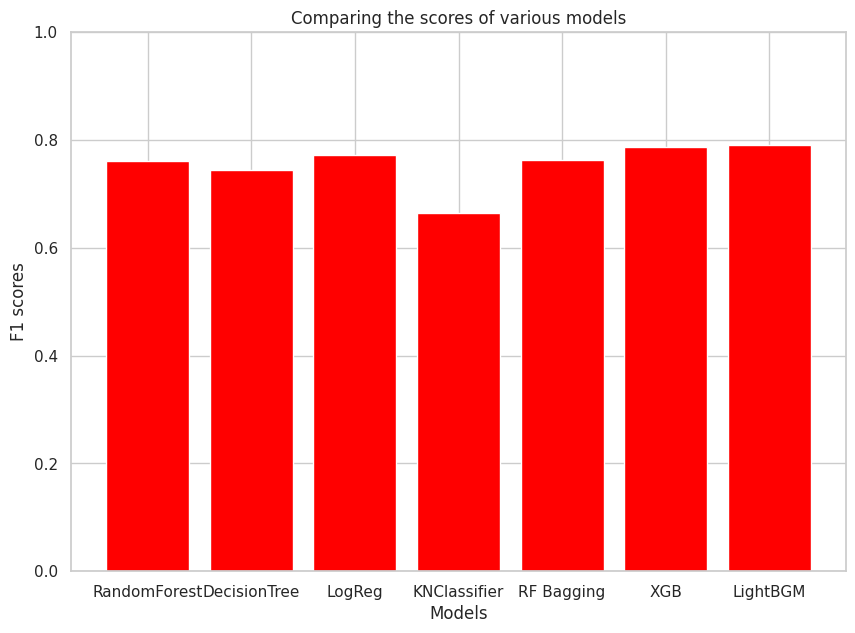

In [63]:
models=['RandomForest','DecisionTree','LogReg','KNClassifier','RF Bagging','XGB','LightBGM']
scores=[0.76126,0.74532,0.77232,0.6645,0.76232,0.78662,0.79142]
plt.figure(figsize=(10,7))
plt.bar(models,scores,color='red')
plt.xlabel('Models')
plt.ylabel('F1 scores')
plt.title('Comparing the scores of various models')
plt.ylim(0,1)
plt.show()


***Confusion Matrix with the validation and training data with the Best Model***

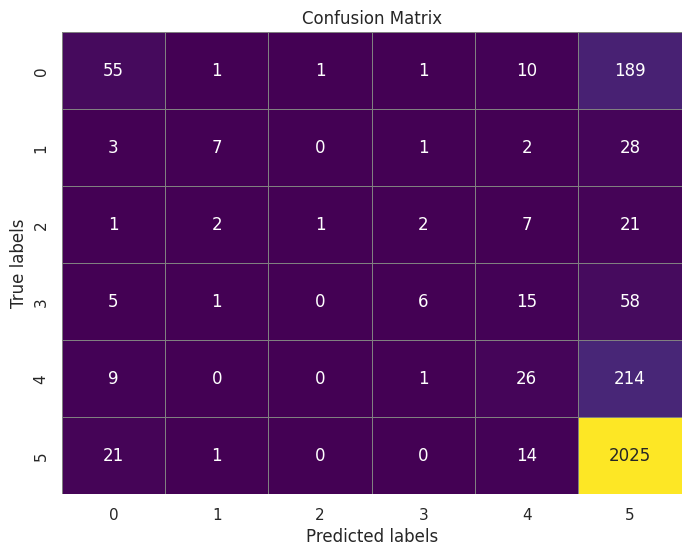

In [64]:
conf_matrix = confusion_matrix(y_valid, ypredictclass)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', cbar=False, linewidths=0.5, linecolor='gray')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()